# Person-Car Detection using YoloV3 TF2 GPU Colab Notebook by Taheri

##### 1.  Clone and install dependencies 

**IMPORTANT**: Restart following the instruction

In [1]:
!git clone https://github.com/taheritajar/experts-group.git
%cd experts-group/
!pip install -r requirements-gpu.txt

Cloning into 'experts-group'...
remote: Enumerating objects: 149, done.
remote: Counting objects: 100% (149/149), done.
remote: Compressing objects: 100% (111/111), done.
remote: Total 149 (delta 63), reused 105 (delta 31), pack-reused 0
Receiving objects: 100% (149/149), 17.04 MiB | 45.79 MiB/s, done.
Resolving deltas: 100% (63/63), done.
/content/experts-group
Obtaining file:///content/experts-group (from -r requirements-gpu.txt (line 6))
     |████████████████████████████████| 394.7MB 26kB/s 
     |████████████████████████████████| 28.7MB 119kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
  Running setup.py develop for yolov3-tf2


##### 2.  Check Tensorflow2 version

In [2]:
!ls

import tensorflow as tf
tf.__version__

conda-cpu.yml  detect_video.py	    map-calc		  tools
conda-gpu.yml  docs		    README.md		  train.py
convert.py     expert-dataset.rar   requirements-gpu.txt  yolov3_tf2
data	       experts_colab.ipynb  requirements.txt	  yolov3_tf2.egg-info
detect.py      LICENSE		    setup.py


'2.4.0'

##### 3.  Convert Pretrained Darknet Weight

In [3]:
!wget https://pjreddie.com/media/files/yolov3.weights -O data/yolov3.weights
!python convert.py

--2021-01-18 19:18:53--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘data/yolov3.weights’

data/yolov3.weights 100%[===================>] 236.52M  2.77MB/s    in 2m 4s   

2021-01-18 19:20:57 (1.91 MB/s) - ‘data/yolov3.weights’ saved [248007048/248007048]

2021-01-18 19:20:57.573209: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2021-01-18 19:20:57.573250: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-01-18 19:20:59.213751: I tensorflow/compiler/jit/xla_cpu_device.cc:41

In [4]:
!pwd

/content/experts-group


##### 4. Initialize Detector

In [5]:
import sys
from absl import app, logging, flags
from absl.flags import FLAGS
import time
import cv2
import numpy as np
import tensorflow as tf
from yolov3_tf2.models import (
    YoloV3, YoloV3Tiny
)
from yolov3_tf2.dataset import transform_images, load_tfrecord_dataset
from yolov3_tf2.utils import draw_outputs

flags.DEFINE_string('classes', './data/coco.names', 'path to classes file')
flags.DEFINE_string('weights', './checkpoints/yolov3.tf',
                    'path to weights file')
flags.DEFINE_boolean('tiny', False, 'yolov3 or yolov3-tiny')
flags.DEFINE_integer('size', 416, 'resize images to')
flags.DEFINE_string('image', './data/girl.png', 'path to input image')
flags.DEFINE_string('tfrecord', None, 'tfrecord instead of image')
flags.DEFINE_string('output', './output.jpg', 'path to output image')
flags.DEFINE_integer('num_classes', 80, 'number of classes in the model')

app._run_init(['yolov3'], app.parse_flags_with_usage)

physical_devices = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

##### 4. Detect Image

I0118 19:21:07.137310 139926828971904 <ipython-input-6-8266b2c611f7>:9] weights loaded
I0118 19:21:07.138696 139926828971904 <ipython-input-6-8266b2c611f7>:12] classes loaded
I0118 19:21:08.293064 139926828971904 <ipython-input-6-8266b2c611f7>:23] time: 1.1205494403839111
I0118 19:21:08.296454 139926828971904 <ipython-input-6-8266b2c611f7>:25] detections:
I0118 19:21:08.299977 139926828971904 <ipython-input-6-8266b2c611f7>:29] 	car, 0.9966800808906555, [0.26270664 0.34669653 0.40587908 0.5401914 ]
I0118 19:21:08.302337 139926828971904 <ipython-input-6-8266b2c611f7>:29] 	bus, 0.9952293038368225, [0.32288754 0.15145975 0.6138201  0.506682  ]
I0118 19:21:08.304331 139926828971904 <ipython-input-6-8266b2c611f7>:29] 	bus, 0.9951197504997253, [0.67014587 0.17855005 0.9937171  0.5290145 ]
I0118 19:21:08.308338 139926828971904 <ipython-input-6-8266b2c611f7>:29] 	person, 0.9875381588935852, [0.6138847  0.34505445 0.68770576 0.77529997]
I0118 19:21:08.312487 139926828971904 <ipython-input-6-8266

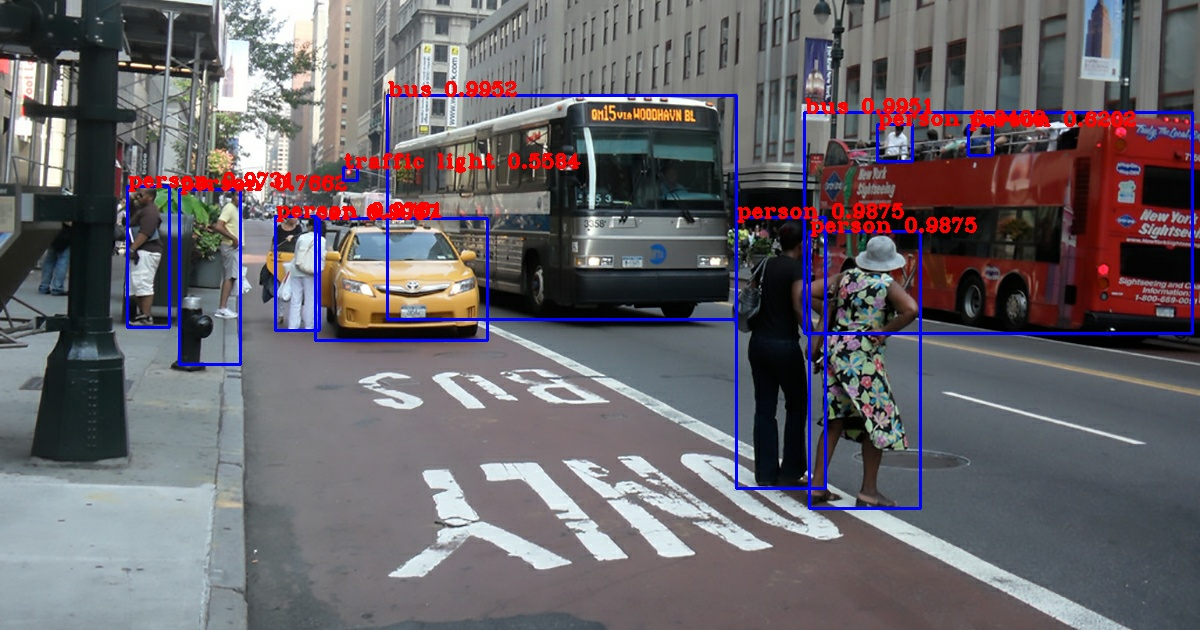

In [6]:
FLAGS.image = 'data/street.jpg'

if FLAGS.tiny:
    yolo = YoloV3Tiny(classes=FLAGS.num_classes)
else:
    yolo = YoloV3(classes=FLAGS.num_classes)
      
yolo.load_weights(FLAGS.weights).expect_partial()
logging.info('weights loaded')

class_names = [c.strip() for c in open(FLAGS.classes).readlines()]
logging.info('classes loaded')

img_raw = tf.image.decode_image(
    open(FLAGS.image, 'rb').read(), channels=3)

img = tf.expand_dims(img_raw, 0)
img = transform_images(img, FLAGS.size)

t1 = time.time()
boxes, scores, classes, nums = yolo(img)
t2 = time.time()
logging.info('time: {}'.format(t2 - t1))

logging.info('detections:')
for i in range(nums[0]):
    logging.info('\t{}, {}, {}'.format(class_names[int(classes[0][i])],
                                        np.array(scores[0][i]),
                                        np.array(boxes[0][i])))

img = cv2.cvtColor(img_raw.numpy(), cv2.COLOR_RGB2BGR)
img = draw_outputs(img, (boxes, scores, classes, nums), class_names)

from IPython.display import Image, display
display(Image(data=bytes(cv2.imencode('.jpg', img)[1]), width=800))

##### 5. Training New Dataset

In [7]:
# !wget http://host.robots.ox.ac.uk/pascal/VOC/voc2009/VOCtrainval_11-May-2009.tar -O ./data/voc2009_raw.tar
# !mkdir -p ./data/voc2009_raw
# !tar -xf ./data/voc2009_raw.tar -C ./data/voc2009_raw
!unrar x "./expert-dataset.rar" "./dataset/"


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from ./expert-dataset.rar

Creating    ./dataset                                                 OK
Creating    ./dataset/test                                            OK
Extracting  ./dataset/test/13_Interview_Interview_2_People_Visible_13_107.jpg       0%  1%  OK 
Extracting  ./dataset/test/13_Interview_Interview_2_People_Visible_13_107.xml       1%  OK 
Extracting  ./dataset/test/13_Interview_Interview_2_People_Visible_13_217.jpg       1%  2%  OK 
Extracting  ./dataset/test/13_Interview_Interview_2_People_Visible_13_217.xml       2%  OK 
Extracting  ./dataset/test/13_Interview_Interview_2_People_Visible_13_241.jpg       3%  OK 
Extracting  ./dataset/test/13_Interview_Interview_2_People_Visible_13_241.xml       3%  OK 
Extracting  ./dataset/test/1_Handshaking_Handshaking_1_107.jpg             3%  4%  OK 
Extracting  ./dataset/tes

In [8]:
!pwd

/content/experts-group


In [9]:
!python tools/voc2012.py \
  --data_dir './dataset/train' \
  --split train \
  --classes './data/expert.names' \
  --output_file ./data/expert_train.tfrecord

!python tools/voc2012.py \
  --data_dir './dataset/val' \
  --split val \
  --classes './data/expert.names' \
  --output_file ./data/expert_val.tfrecord

2021-01-18 19:21:08.995744: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2021-01-18 19:21:08.995790: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
I0118 19:21:10.818805 139974724409216 voc2012.py:116] Class mapping loaded: {'person': 0, 'car': 1}
I0118 19:21:10.819276 139974724409216 voc2012.py:121] Image list loaded: 28
100% 28/28 [00:00<00:00, 896.72it/s]
I0118 19:21:10.853271 139974724409216 voc2012.py:130] Done
2021-01-18 19:21:11.403723: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2021-01-18 19:21:11.403764: I tensorfl

In [10]:
!python tools/visualize_dataset.py --dataset ./data/expert_train.tfrecord --classes=./data/expert.names

2021-01-18 19:21:13.796659: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2021-01-18 19:21:13.796703: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
I0118 19:21:15.408823 140298307626880 visualize_dataset.py:24] classes loaded
2021-01-18 19:21:15.409211: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-01-18 19:21:15.410060: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-01-18 19:21:15.415126: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2

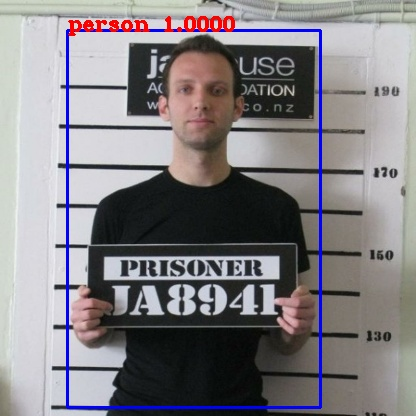

In [11]:
from IPython.display import Image
Image(filename='./output.jpg')

In [12]:
!python train.py \
	--dataset ./data/expert_train.tfrecord \
	--val_dataset ./data/expert_val.tfrecord \
	--classes ./data/expert.names \
	--num_classes 2 \
	--mode fit --transfer darknet \
	--batch_size 16 \
	--epochs 4 \
	--weights ./checkpoints/yolov3.tf \
	--weights_num_classes 80 

2021-01-18 19:21:16.518246: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2021-01-18 19:21:16.518286: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-01-18 19:21:18.221533: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-01-18 19:21:18.222416: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-01-18 19:21:18.227747: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-01-18 19:21:18.228319: I tensorflow/core/common_runtime/gpu/gpu_device.cc:

##### 6. Detect using new weights

I0118 19:25:24.014668 139926828971904 <ipython-input-13-97ecafa9fee2>:16] weights loaded
I0118 19:25:24.016067 139926828971904 <ipython-input-13-97ecafa9fee2>:19] classes loaded
I0118 19:25:25.092287 139926828971904 <ipython-input-13-97ecafa9fee2>:29] time: 1.0595059394836426
I0118 19:25:25.094006 139926828971904 <ipython-input-13-97ecafa9fee2>:31] detections:
I0118 19:25:25.098747 139926828971904 <ipython-input-13-97ecafa9fee2>:35] 	car, 0.9273992776870728, [0.34890455 0.8221314  0.3635444  0.83130586]
I0118 19:25:25.102036 139926828971904 <ipython-input-13-97ecafa9fee2>:35] 	car, 0.9269179105758667, [0.38109976 0.8211815  0.40583992 0.83212024]
I0118 19:25:25.105261 139926828971904 <ipython-input-13-97ecafa9fee2>:35] 	car, 0.924278974533081, [0.36441892 0.8212252  0.38289434 0.83203405]
I0118 19:25:25.108084 139926828971904 <ipython-input-13-97ecafa9fee2>:35] 	car, 0.9237494468688965, [0.38416702 0.8029907  0.39823025 0.8119606 ]
I0118 19:25:25.111010 139926828971904 <ipython-input-1

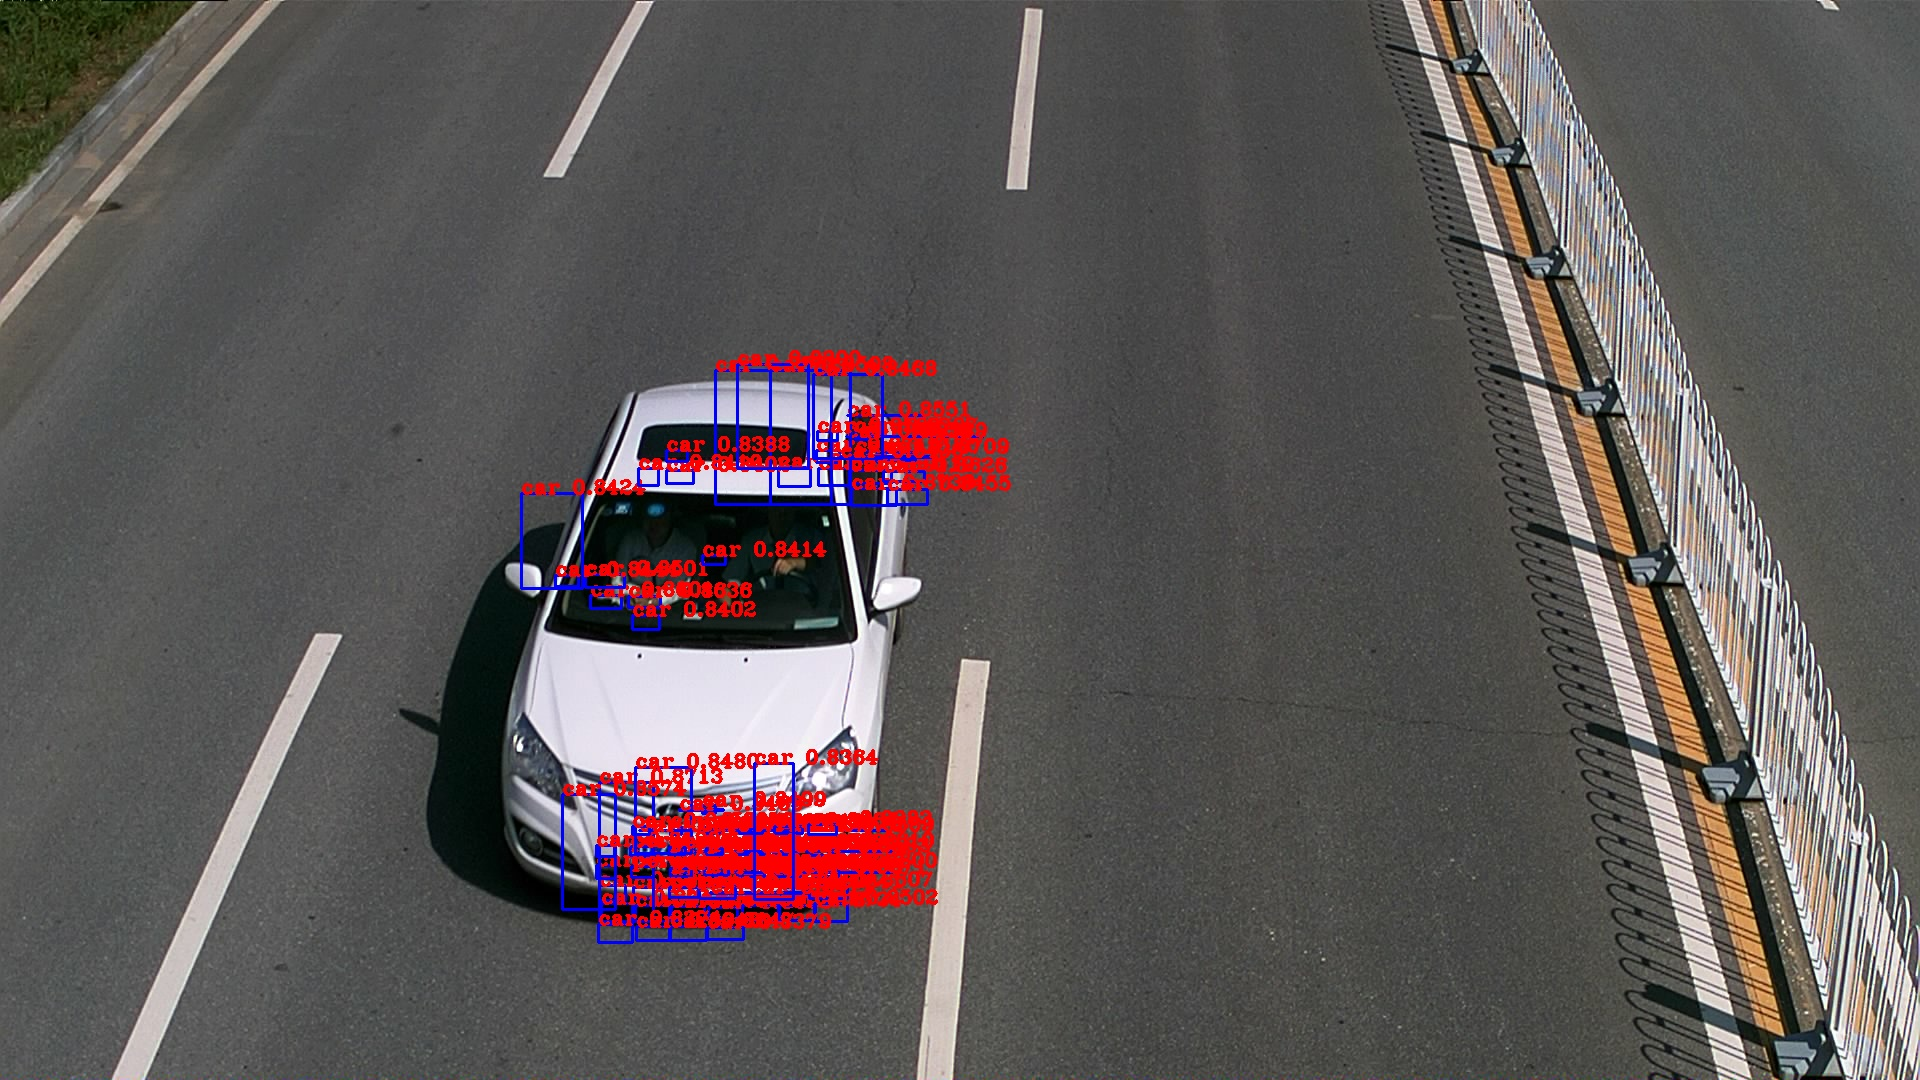

In [13]:
FLAGS.num_classes = 2
FLAGS.classes = './data/expert.names'
FLAGS.weights = 'checkpoints/yolov3_train_4.tf'
FLAGS.image = './dataset/test/vehicle_0000199.jpg'  

# Lower threshold due to insufficient training
FLAGS.yolo_iou_threshold = 0.6
FLAGS.yolo_score_threshold = 0.65

if FLAGS.tiny:
    yolo = YoloV3Tiny(classes=FLAGS.num_classes)
else:
    yolo = YoloV3(classes=FLAGS.num_classes)

yolo.load_weights(FLAGS.weights).expect_partial()
logging.info('weights loaded')

class_names = [c.strip() for c in open(FLAGS.classes).readlines()]
logging.info('classes loaded')

img_raw = tf.image.decode_image(open(FLAGS.image, 'rb').read(), channels=3)

img = tf.expand_dims(img_raw, 0)
img = transform_images(img, FLAGS.size)

t1 = time.time()
boxes, scores, classes, nums = yolo(img)
t2 = time.time()
logging.info('time: {}'.format(t2 - t1))

logging.info('detections:')
for i in range(nums[0]):
    logging.info('\t{}, {}, {}'.format(class_names[int(classes[0][i])],
                                        np.array(scores[0][i]),
                                        np.array(boxes[0][i])))

img = cv2.cvtColor(img_raw.numpy(), cv2.COLOR_RGB2BGR)
img = draw_outputs(img, (boxes, scores, classes, nums), class_names)

from IPython.display import Image, display
display(Image(data=bytes(cv2.imencode('.jpg', img)[1]), width=800))

In [14]:
# Calculating mAP:
!git clone https://github.com/Cartucho/mAP.git
# Remove tmp data
!rm ./mAP/input/detection-results/*
!rm ./mAP/input/ground-truth/*
!rm ./mAP/input/images-optional/*
# Copy test image data to map Ground Truth:
!cp /content/experts-group/dataset/test/*.xml ./mAP/input/ground-truth/
!cp /content/experts-group/dataset/test/*.jpg ./mAP/input/images-optional/
# converting .xml ti .txt and changing their format
!python ./mAP/scripts/extra/convert_gt_xml.py

Cloning into 'mAP'...
remote: Enumerating objects: 908, done.
remote: Total 908 (delta 0), reused 0 (delta 0), pack-reused 908
Receiving objects: 100% (908/908), 14.71 MiB | 42.92 MiB/s, done.
Resolving deltas: 100% (321/321), done.
Conversion completed!


I0118 19:26:26.447259 139926828971904 <ipython-input-17-f86653403ba5>:18] weights loaded
I0118 19:26:26.448660 139926828971904 <ipython-input-17-f86653403ba5>:21] classes loaded


./dataset/test/13_Interview_Interview_2_People_Visible_13_107.jpg


I0118 19:26:27.500897 139926828971904 <ipython-input-17-f86653403ba5>:38] time: 1.0392911434173584
I0118 19:26:27.501733 139926828971904 <ipython-input-17-f86653403ba5>:40] detections:


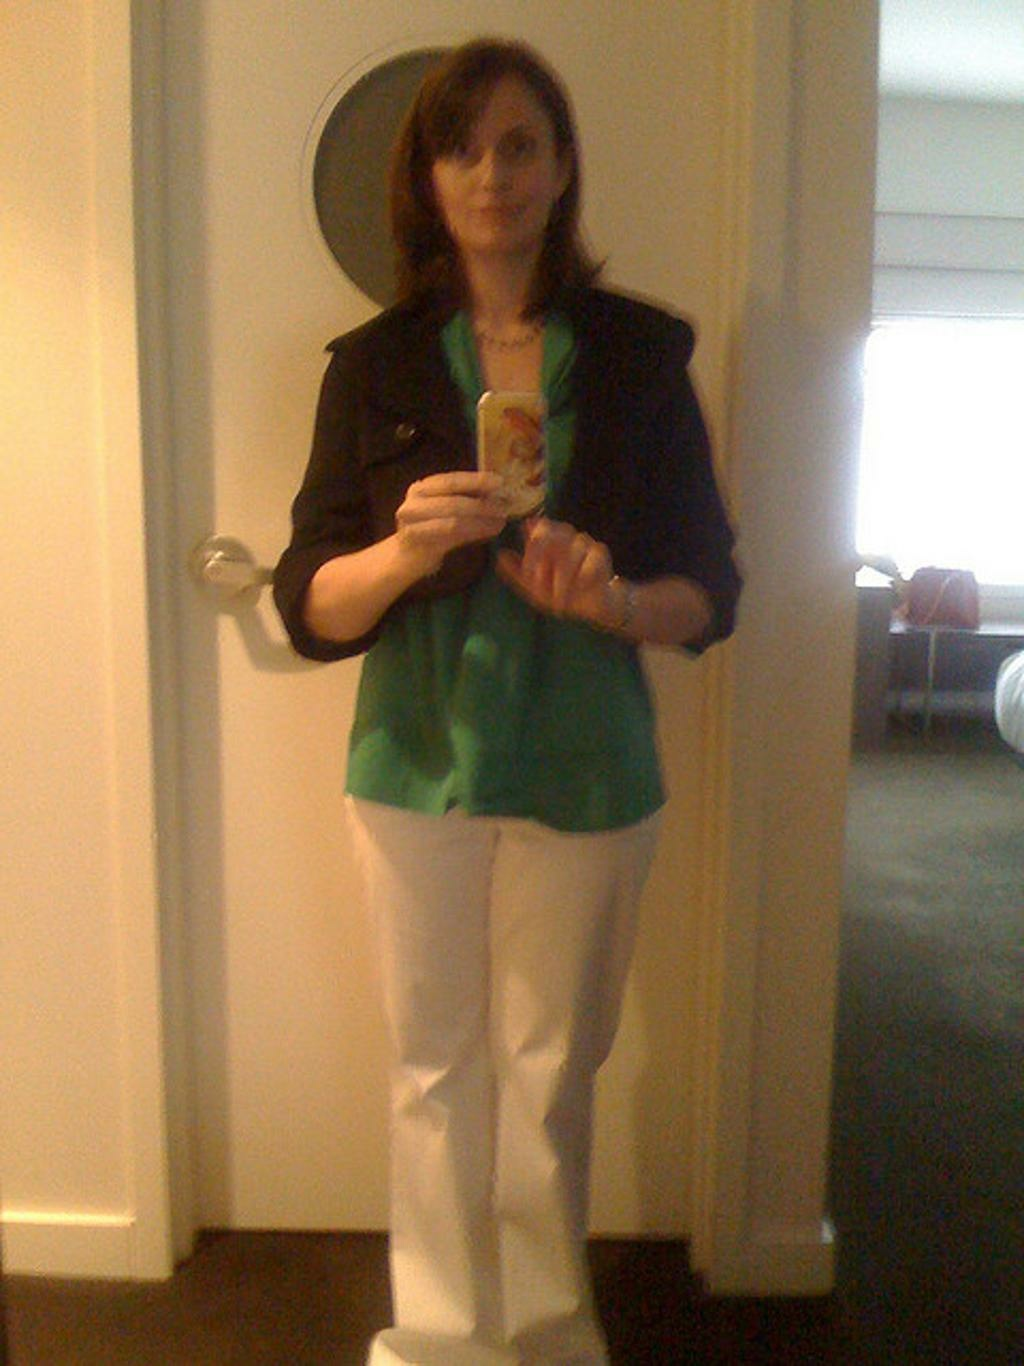

./dataset/test/13_Interview_Interview_2_People_Visible_13_217.jpg


I0118 19:26:28.614335 139926828971904 <ipython-input-17-f86653403ba5>:38] time: 1.061457872390747
I0118 19:26:28.615142 139926828971904 <ipython-input-17-f86653403ba5>:40] detections:
I0118 19:26:28.621415 139926828971904 <ipython-input-17-f86653403ba5>:47] 	car, 0.971983015537262, [0.8113557  0.05029638 0.8336526  0.064995  ]
I0118 19:26:28.627939 139926828971904 <ipython-input-17-f86653403ba5>:47] 	car, 0.9703729152679443, [0.82869613 0.05338401 0.85215855 0.06179453]
I0118 19:26:28.633990 139926828971904 <ipython-input-17-f86653403ba5>:47] 	car, 0.9619175791740417, [0.8468057  0.05301508 0.8670479  0.06206238]
I0118 19:26:28.639801 139926828971904 <ipython-input-17-f86653403ba5>:47] 	car, 0.9511764049530029, [0.77279025 0.         0.8034447  0.08466867]


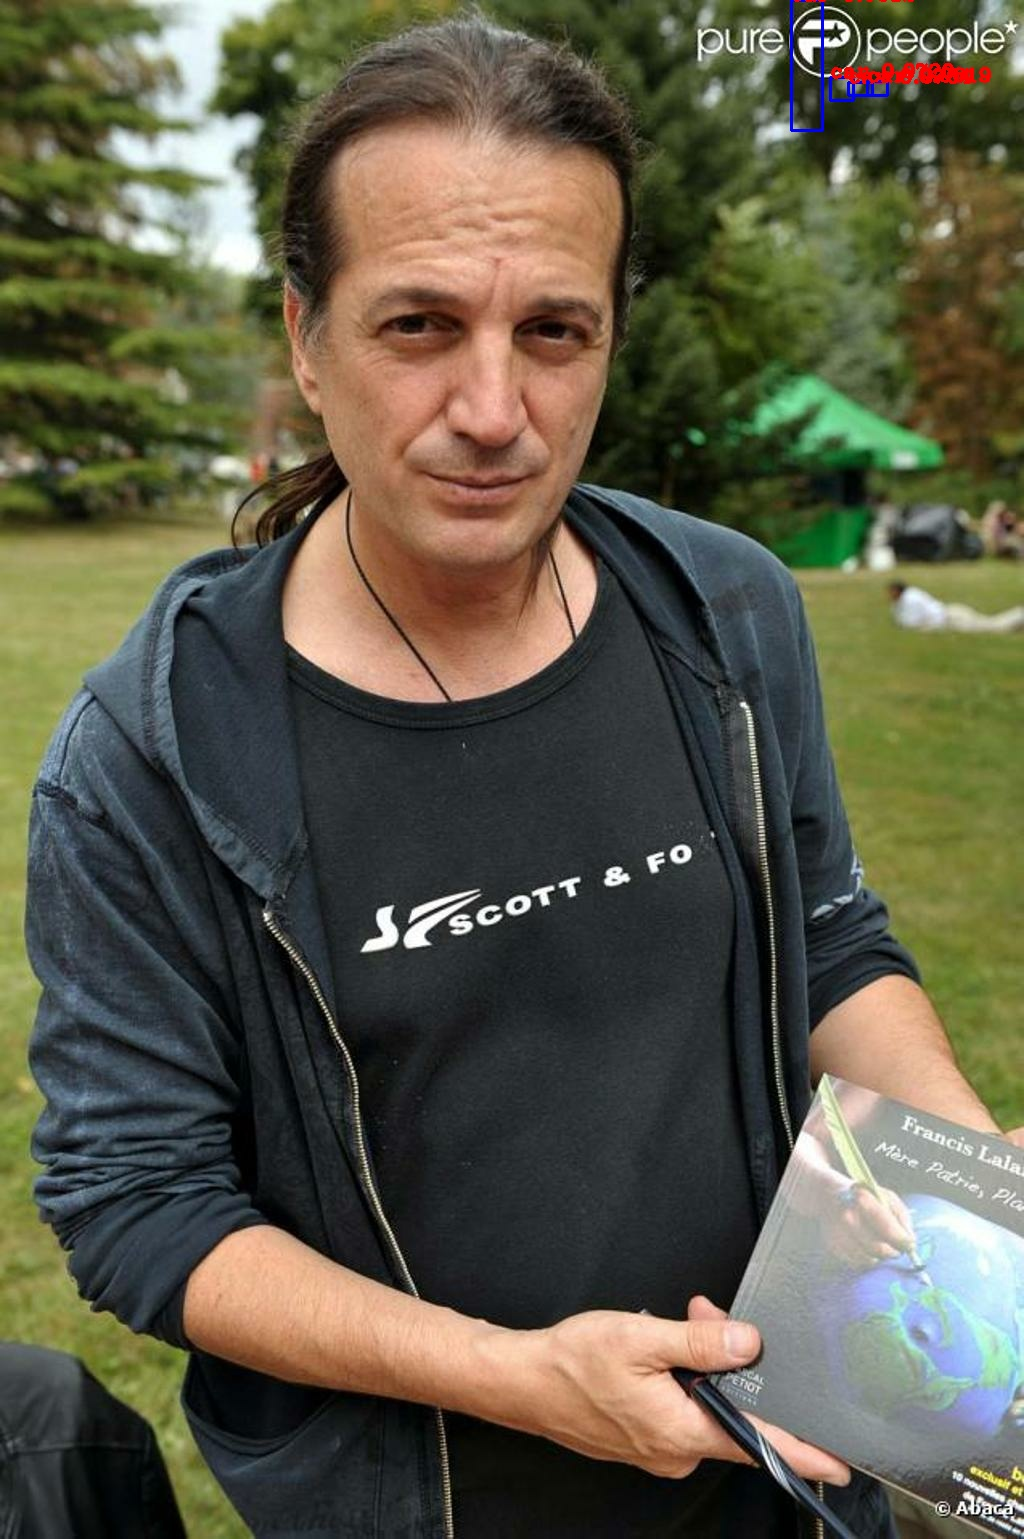

./dataset/test/13_Interview_Interview_2_People_Visible_13_241.jpg


I0118 19:26:29.778041 139926828971904 <ipython-input-17-f86653403ba5>:38] time: 1.093372106552124
I0118 19:26:29.779446 139926828971904 <ipython-input-17-f86653403ba5>:40] detections:


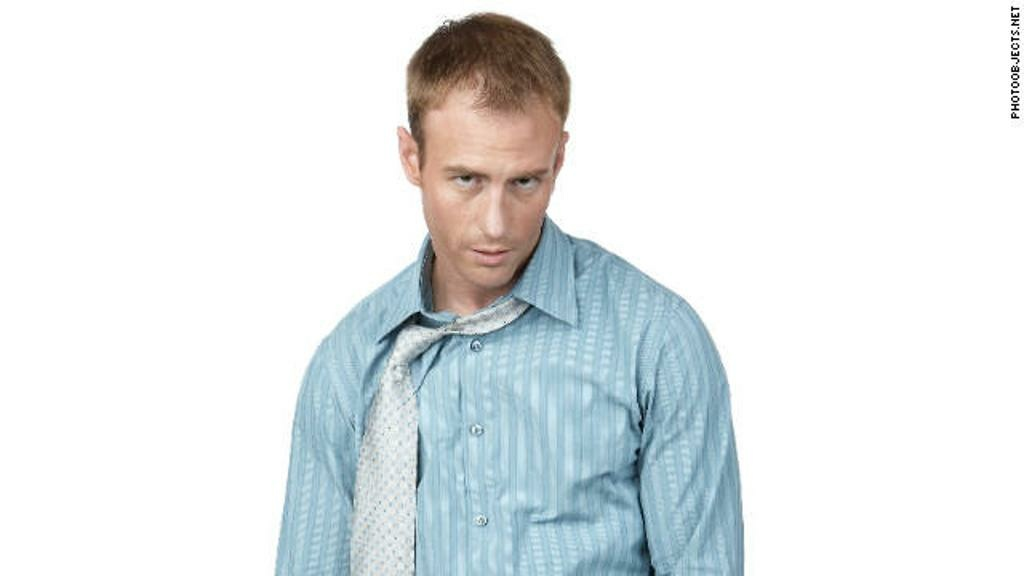

./dataset/test/1_Handshaking_Handshaking_1_107.jpg


I0118 19:26:30.837078 139926828971904 <ipython-input-17-f86653403ba5>:38] time: 1.0306267738342285
I0118 19:26:30.839711 139926828971904 <ipython-input-17-f86653403ba5>:40] detections:
I0118 19:26:30.843297 139926828971904 <ipython-input-17-f86653403ba5>:47] 	car, 0.9819907546043396, [0.94449234 0.95906943 0.9484514  0.96394426]
I0118 19:26:30.849327 139926828971904 <ipython-input-17-f86653403ba5>:47] 	car, 0.9788504242897034, [0.94815314 0.977486   0.96251047 0.98393905]
I0118 19:26:30.853209 139926828971904 <ipython-input-17-f86653403ba5>:47] 	car, 0.973781168460846, [0.9307963  0.96805024 0.9456064  0.99344015]
I0118 19:26:30.859342 139926828971904 <ipython-input-17-f86653403ba5>:47] 	car, 0.9677104949951172, [0.4670727 0.6111889 0.4740046 0.6194844]
I0118 19:26:30.863633 139926828971904 <ipython-input-17-f86653403ba5>:47] 	car, 0.9670659303665161, [0.92909676 0.95740235 0.9327423  0.96563303]
I0118 19:26:30.868130 139926828971904 <ipython-input-17-f86653403ba5>:47] 	car, 0.96629863

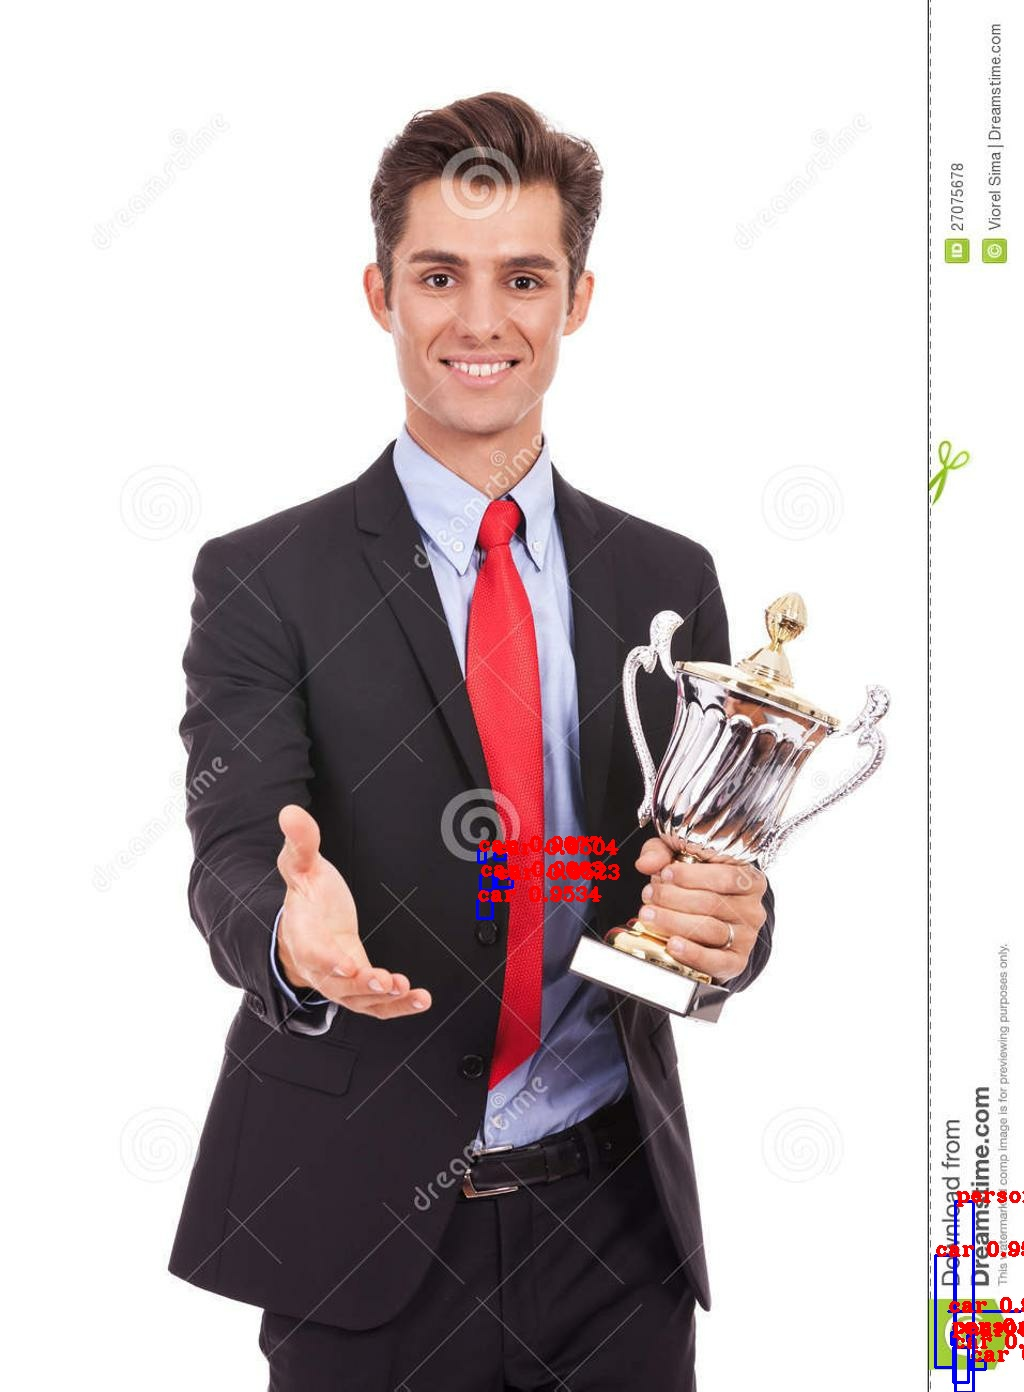

./dataset/test/1_Handshaking_Handshaking_1_275.jpg


I0118 19:26:32.022211 139926828971904 <ipython-input-17-f86653403ba5>:38] time: 1.0686120986938477
I0118 19:26:32.023003 139926828971904 <ipython-input-17-f86653403ba5>:40] detections:


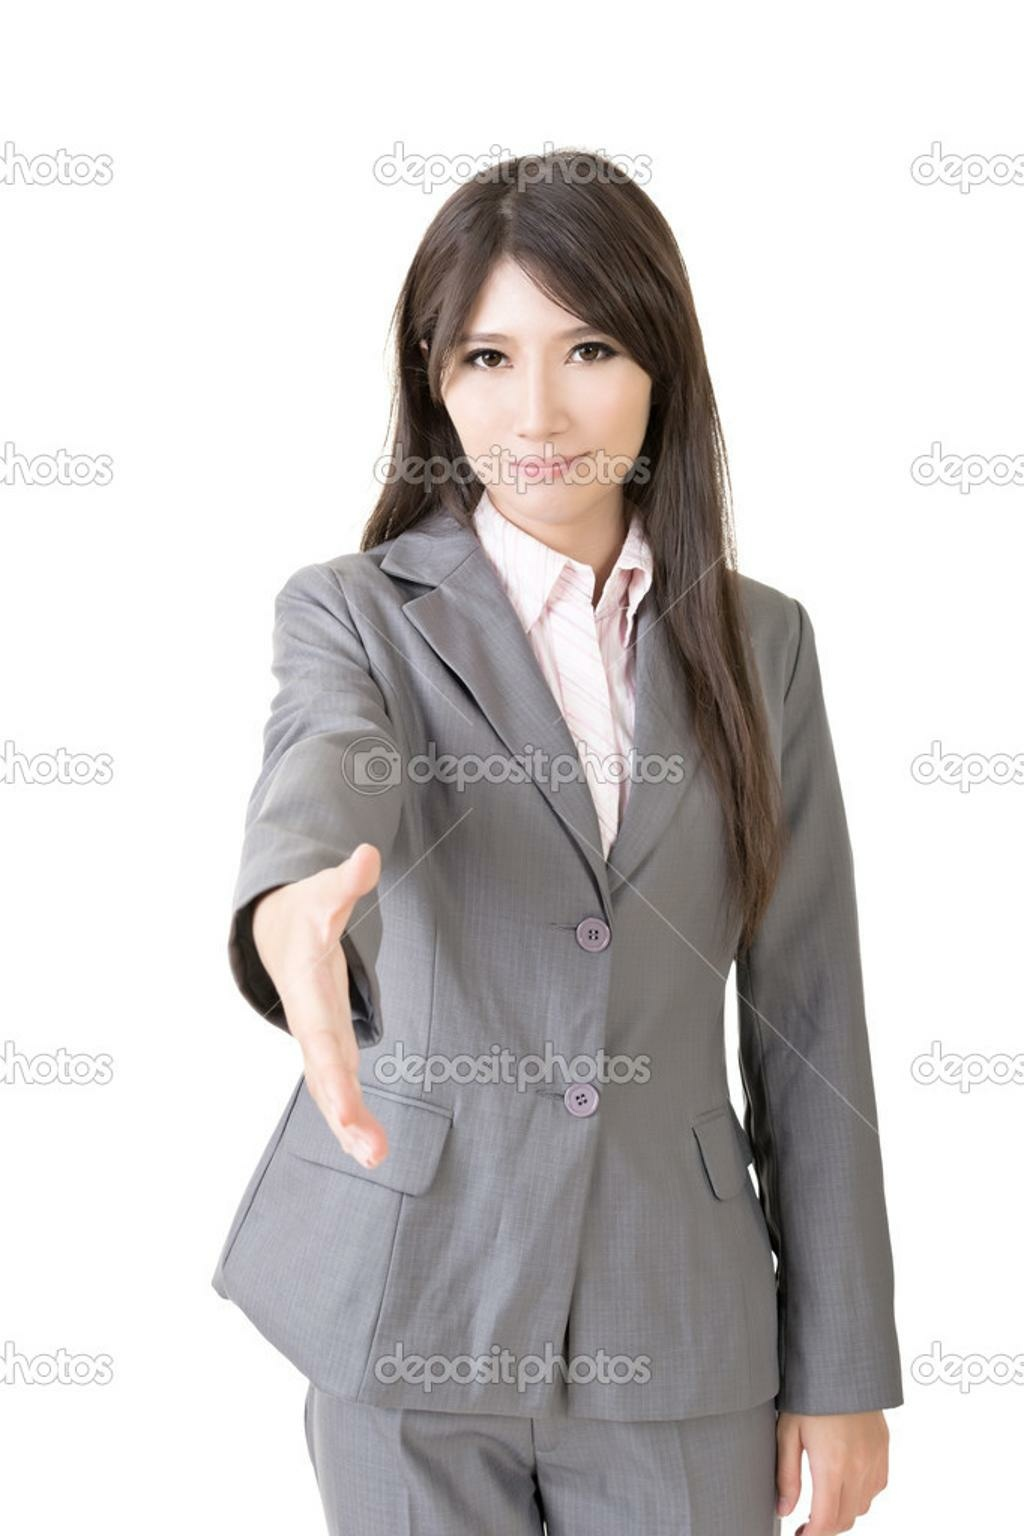

./dataset/test/vehicle_0000177.jpg


I0118 19:26:33.181257 139926828971904 <ipython-input-17-f86653403ba5>:38] time: 1.1046268939971924
I0118 19:26:33.182504 139926828971904 <ipython-input-17-f86653403ba5>:40] detections:


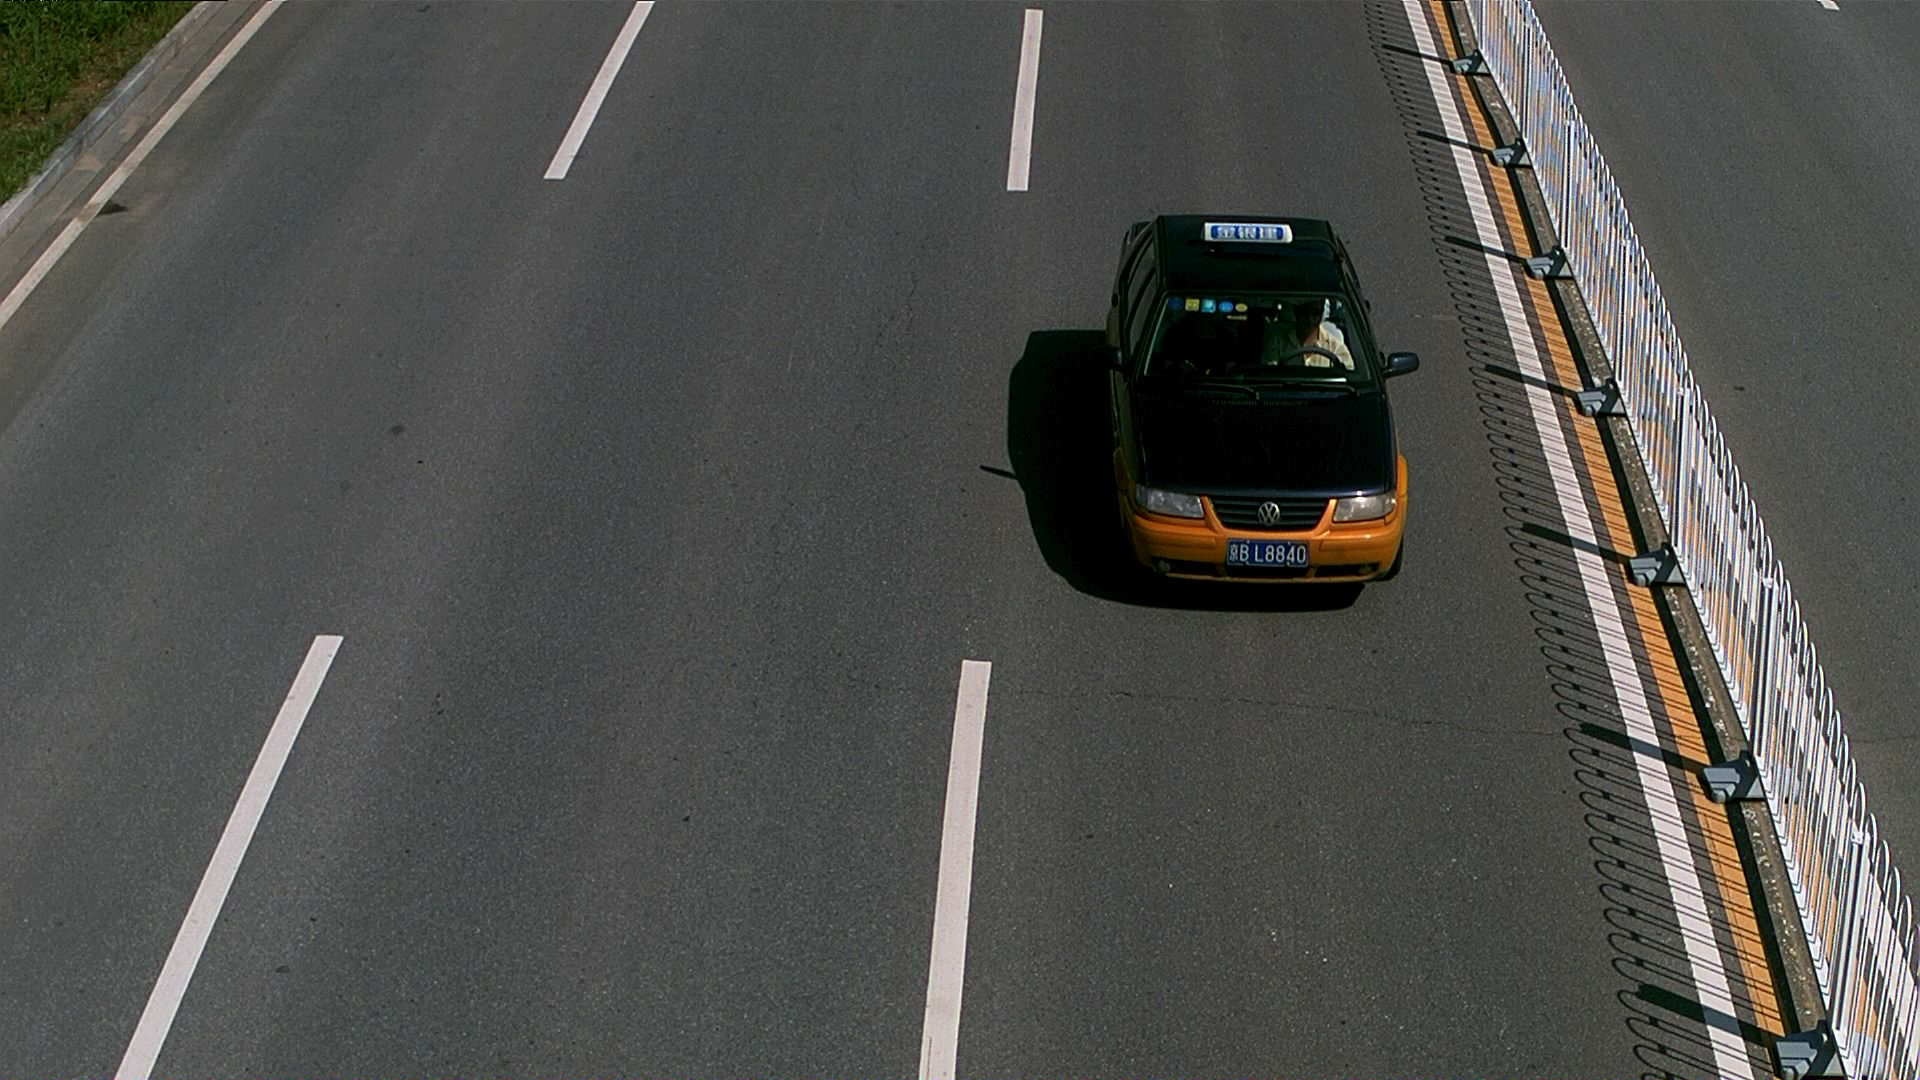

./dataset/test/vehicle_0000199.jpg


I0118 19:26:34.379439 139926828971904 <ipython-input-17-f86653403ba5>:38] time: 1.1275558471679688
I0118 19:26:34.381575 139926828971904 <ipython-input-17-f86653403ba5>:40] detections:


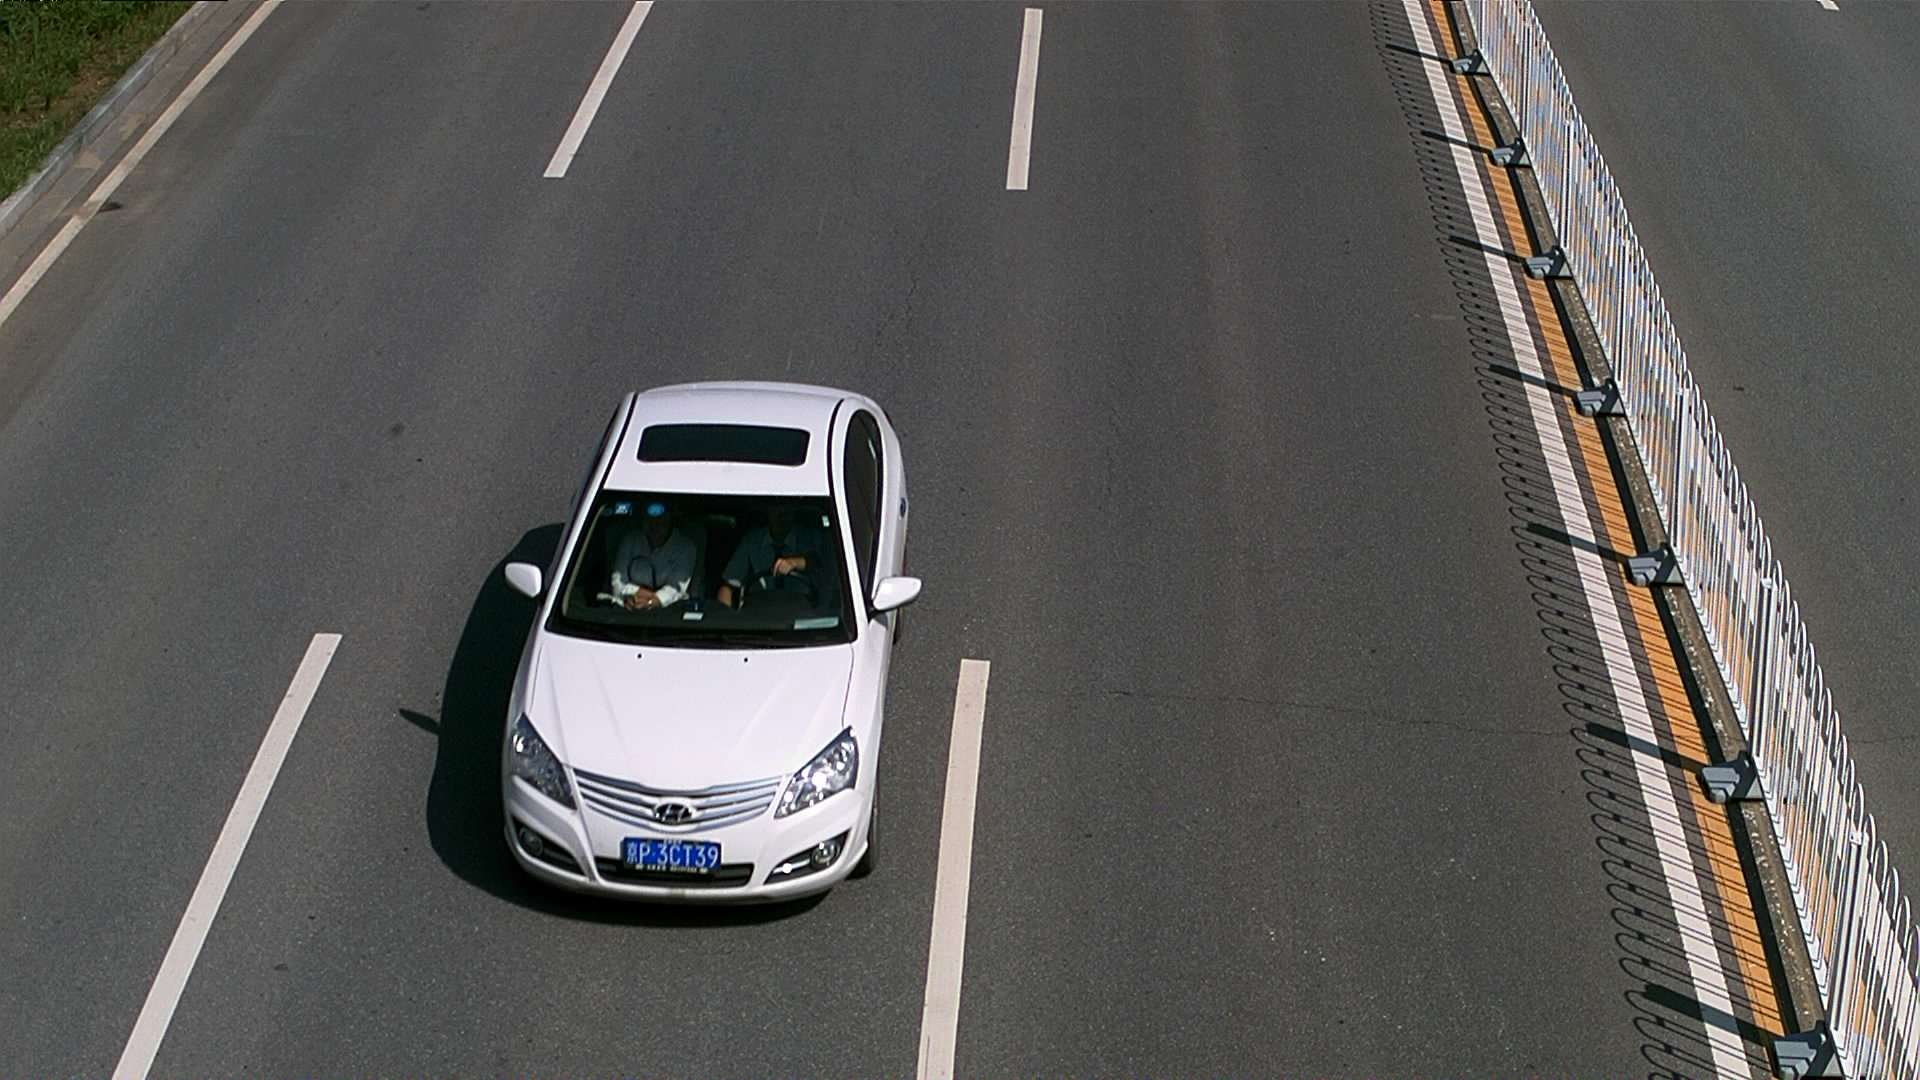

./dataset/test/vehicle_0000229.jpg


I0118 19:26:35.526416 139926828971904 <ipython-input-17-f86653403ba5>:38] time: 1.0838985443115234
I0118 19:26:35.527394 139926828971904 <ipython-input-17-f86653403ba5>:40] detections:


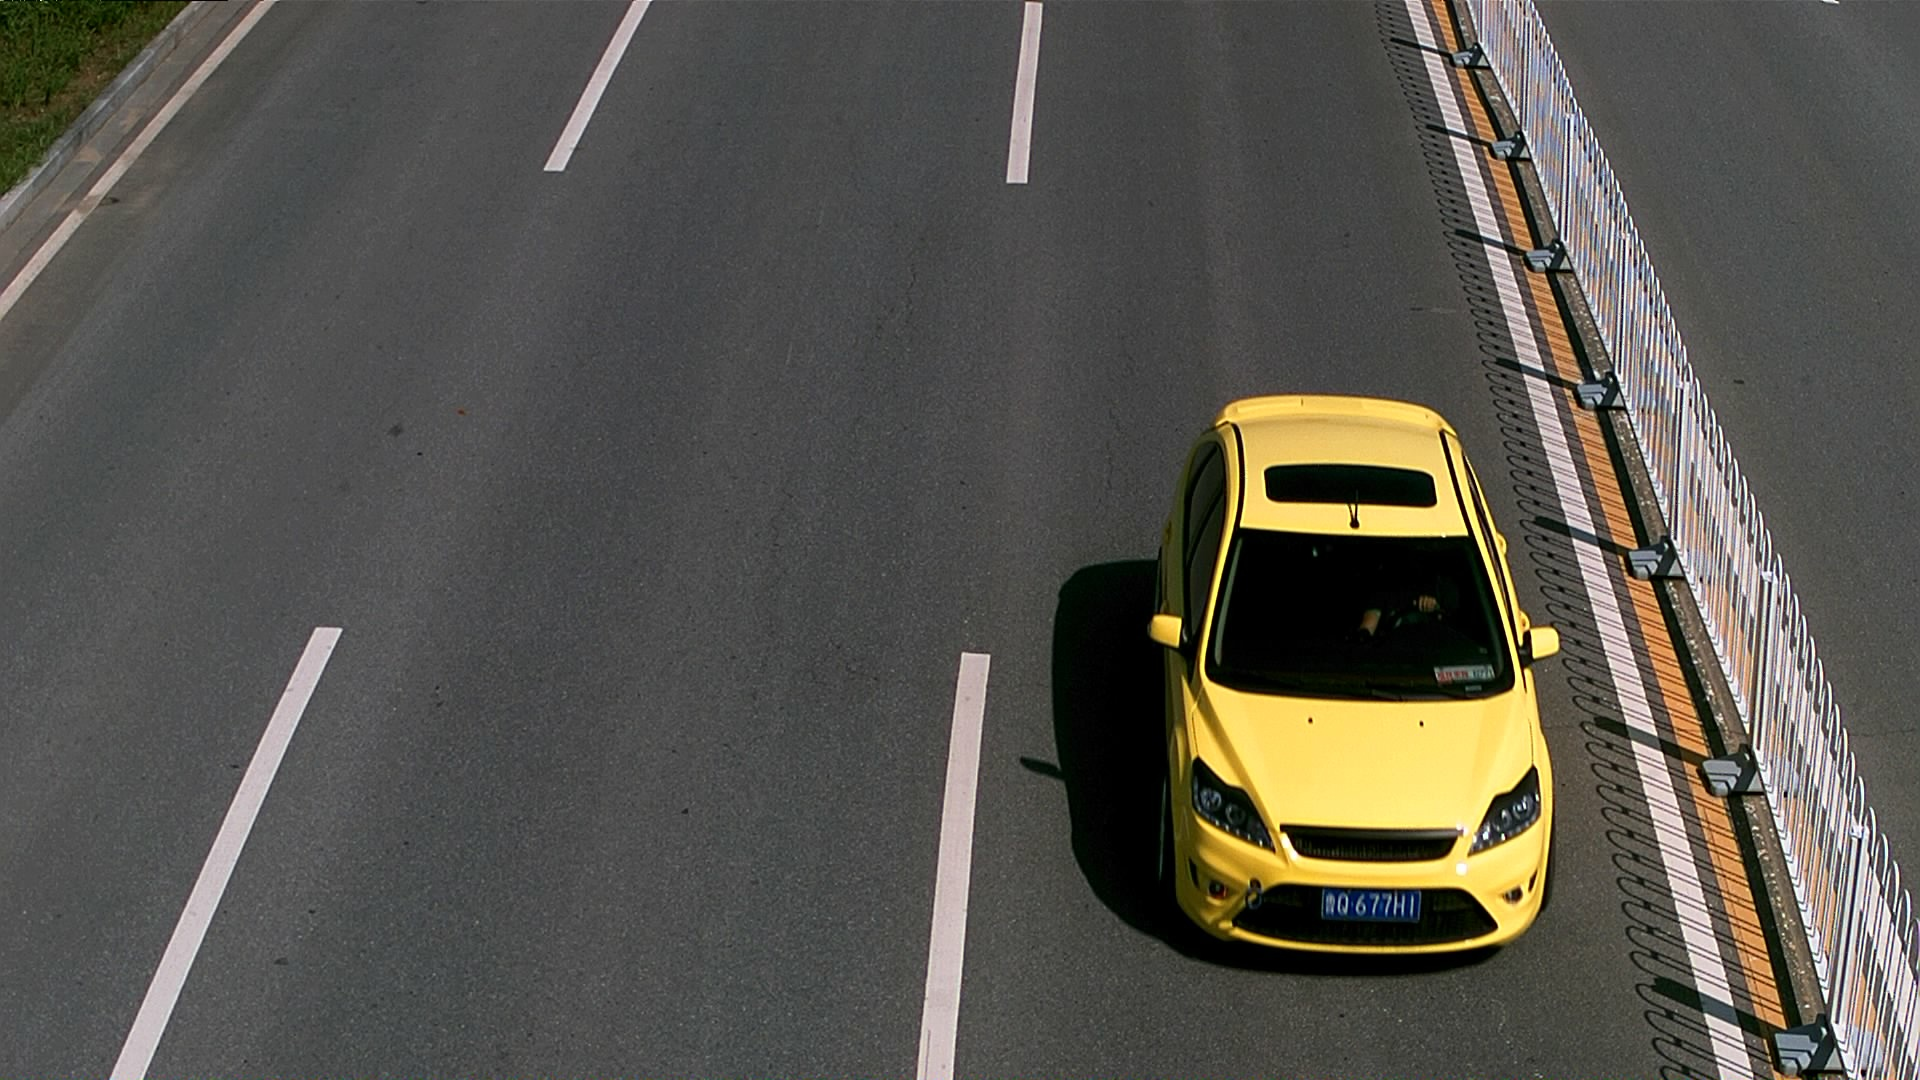

./dataset/test/vehicle_0000245.jpg


I0118 19:26:36.762596 139926828971904 <ipython-input-17-f86653403ba5>:38] time: 1.1658058166503906
I0118 19:26:36.763503 139926828971904 <ipython-input-17-f86653403ba5>:40] detections:


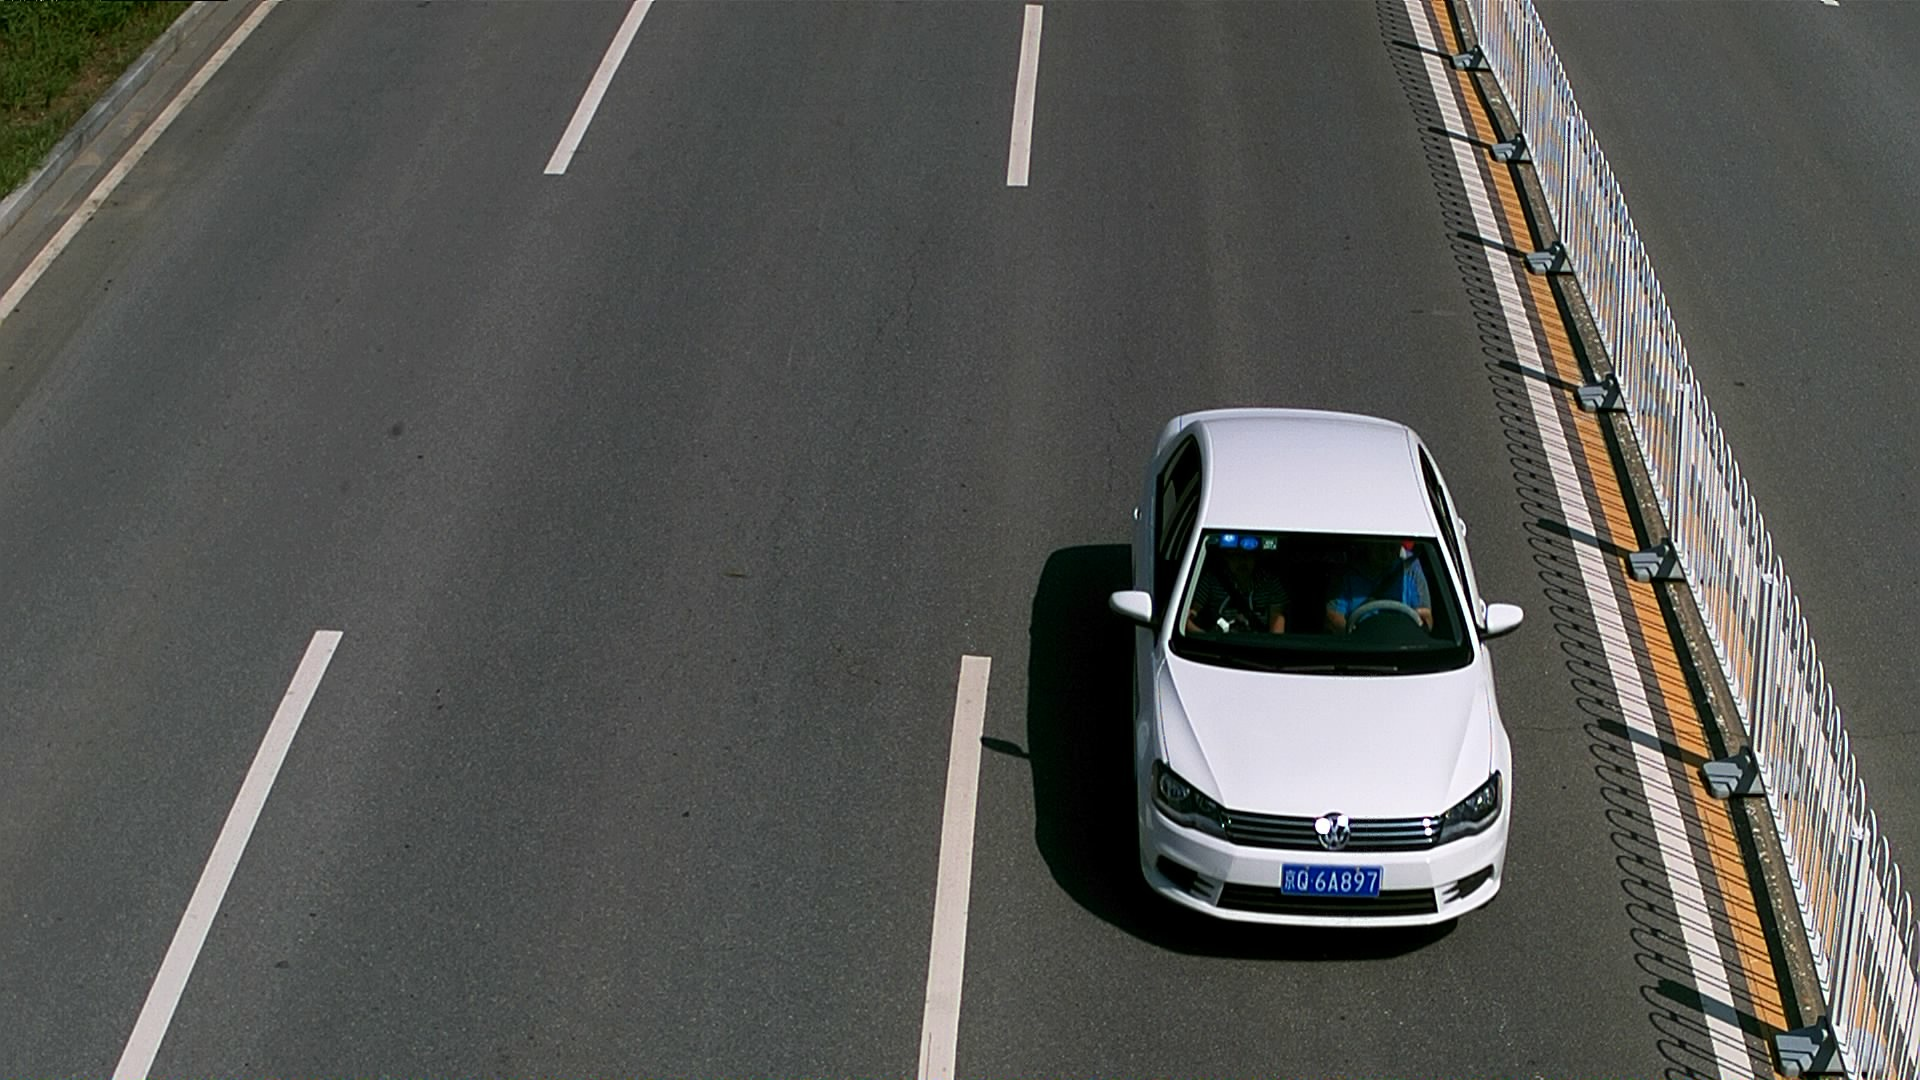

In [17]:
FLAGS.num_classes = 2
FLAGS.classes = './data/expert.names'
FLAGS.weights = 'checkpoints/yolov3_train_4.tf'
images = './dataset/test/test.txt'  
images_dir = './dataset/test/'
output_dir = './mAP/input/detection-results/'

# Lower threshold due to insufficient training
FLAGS.yolo_iou_threshold = 0.99
FLAGS.yolo_score_threshold = 0.95

if FLAGS.tiny:
    yolo = YoloV3Tiny(classes=FLAGS.num_classes)
else:
    yolo = YoloV3(classes=FLAGS.num_classes)

yolo.load_weights(FLAGS.weights).expect_partial()
logging.info('weights loaded')

class_names = [c.strip() for c in open(FLAGS.classes).readlines()]
logging.info('classes loaded')

test_images = [c.strip() for c in open(images).readlines()]

for image in test_images:
  img_addr = images_dir + image + '.jpg'
  print(img_addr)

  img_raw = tf.image.decode_image(open(img_addr, 'rb').read(), channels=3)
  wh = img.shape[0:2][1]

  img = tf.expand_dims(img_raw, 0)
  img = transform_images(img, FLAGS.size)

  t1 = time.time()
  boxes, scores, classes, nums = yolo(img)
  t2 = time.time()
  logging.info('time: {}'.format(t2 - t1))

  logging.info('detections:')
  txt_addr = output_dir + image + '.txt'

  with open(txt_addr, "w") as new_f:
    for i in range(nums[0]):
        logging.info('\t{}, {}, {}'.format(class_names[int(classes[0][i])],
                                          np.array(scores[0][i]),
                                          np.array(boxes[0][i])))
        
        new_f.write("%s %s %s %s %s %s\n" % (class_names[int(classes[0][i])],
                                          str(np.array(scores[0][i])),
                                          str(int(np.array(boxes[0][i][0]))* wh),
                                          str(int(np.array(boxes[0][i][1]))* wh),
                                          str(int(np.array(boxes[0][i][2]))* wh),
                                          str(int(np.array(boxes[0][i][3]))* wh)))
      

  img = cv2.cvtColor(img_raw.numpy(), cv2.COLOR_RGB2BGR)
  img = draw_outputs(img, (boxes, scores, classes, nums), class_names)

  from IPython.display import Image, display
  display(Image(data=bytes(cv2.imencode('.jpg', img)[1]), width=800))


In [18]:
!python ./mAP/main.py --no-animation --no-plot

0.00% = car AP 
0.00% = person AP 
mAP = 0.00%
